In [1]:
# If running in a fresh Codespace / environment:
import sys, os, warnings, time
warnings.filterwarnings("ignore")

!{sys.executable} -m pip -q install "dask[complete]" --upgrade

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask
import dask.array as da
from dask.distributed import Client, LocalCluster

/workspaces/computational_methods_course_mariaandradeal/.venv/bin/python: No module named pip


In [2]:
def make_client(n_workers: int, threads_per_worker: int = 1, memory_limit: str = "2GB"):
    """
    Create a fresh local Dask cluster + client.
    Always close clients/clusters after each benchmark to avoid port conflicts.
    """
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=threads_per_worker,
        processes=True,          # separate processes = better CPU scaling
        memory_limit=memory_limit,
        dashboard_address=":0"   # pick any free port automatically
    )
    client = Client(cluster)
    return client, cluster

def close_client(client, cluster):
    try:
        client.close()
    except Exception:
        pass
    try:
        cluster.close()
    except Exception:
        pass


In [3]:
def zscore_dask_array(shape=(8000, 8000), chunks=(1000, 1000), seed=42, dtype=np.float32):
    """
    Create a large random Dask array and return z-score normalized array z=(x-mu)/sigma.

    Notes:
    - Use float32 for memory safety.
    - Dask random is lazy; computation happens when you call .compute().
    """
    rs = da.random.RandomState(seed)
    x = rs.random_sample(shape, chunks=chunks).astype(dtype)

    mu = x.mean()
    sigma = x.std()

    z = (x - mu) / sigma
    return z

In [4]:
def time_one_run(client, shape, chunks, seed=42, dtype=np.float32):
    """
    Build z-score graph and compute it, timing only the compute stage.
    We also call client.restart() to clear worker state between runs if desired.
    """
    # Warmup / clear state (optional but helps comparability)
    # client.restart()

    z = zscore_dask_array(shape=shape, chunks=chunks, seed=seed, dtype=dtype)

    t0 = time.perf_counter()
    _ = z.compute()   # trigger computation
    t1 = time.perf_counter()

    return t1 - t0

In [9]:
def strong_scaling_test(workers_list=(1,2,3,4), 
                        shape=(8000, 8000),
                        chunks=(1000, 1000),
                        repeats=5,
                        memory_limit="2GB",
                        dtype=np.float32):
    """
    Strong scaling: fixed total problem size, vary number of workers.
    Returns a DataFrame with mean/median/std time + speedup + efficiency.
    """
    results = []

    for w in workers_list:
        client, cluster = make_client(n_workers=w, threads_per_worker=1, memory_limit=memory_limit)

        times = []
        for r in range(repeats):
            elapsed = time_one_run(client, shape=shape, chunks=chunks, seed=42+r, dtype=dtype)
            times.append(elapsed)

        close_client(client, cluster)

        results.append({
            "workers": w,
            "time_mean_s": float(np.mean(times)),
            "time_median_s": float(np.median(times)),
            "time_std_s": float(np.std(times, ddof=1)) if repeats > 1 else 0.0
        })

    df = pd.DataFrame(results).sort_values("workers").reset_index(drop=True)

    # Speedup and efficiency
    T1 = df.loc[df["workers"] == 1, "time_mean_s"].values[0]
    df["speedup"] = T1 / df["time_mean_s"]
    df["efficiency"] = df["speedup"] / df["workers"]

    return df

In [6]:
workers = [1, 2, 3, 4]

# ✅ Safe default for Codespaces
# If your machine is strong, try (12000,12000) or (16000,16000) next.
strong_shape  = (8000, 8000)
strong_chunks = (1000, 1000)

df_strong = strong_scaling_test(
    workers_list=workers,
    shape=strong_shape,
    chunks=strong_chunks,
    repeats=5,
    memory_limit="2GB",
    dtype=np.float32
)

df_strong

,workers,time_mean_s,time_median_s,time_std_s,speedup,efficiency
0,1,2.059626,1.853996,0.437680,1.000000,1.000000
1,2,1.972793,1.821403,0.346166,1.044016,0.522008
2,3,2.088607,1.784428,0.730726,0.986124,0.328708
3,4,2.295927,1.948135,0.745314,0.897078,0.224270


In [11]:
def weak_scaling_shapes(base_shape=(6000, 6000), workers_list=(1,2,3,4)):
    """
    Keep work per worker roughly constant by scaling linear dimension ~ sqrt(workers).
    """
    n0, m0 = base_shape
    shapes = {}
    for w in workers_list:
        scale = np.sqrt(w)
        n = int(n0 * scale)
        m = int(m0 * scale)
        shapes[w] = (n, m)
    return shapes

def weak_scaling_test(workers_list=(1,2,3,4),
                      base_shape=(6000, 6000),
                      chunks=(1000, 1000),
                      repeats=5,
                      memory_limit="2GB",
                      dtype=np.float32):
    """
    Weak scaling: scale problem size with workers.
    """
    shapes = weak_scaling_shapes(base_shape=base_shape, workers_list=workers_list)

    results = []
    for w in workers_list:
        client, cluster = make_client(n_workers=w, threads_per_worker=1, memory_limit=memory_limit)

        times = []
        for r in range(repeats):
            elapsed = time_one_run(client, shape=shapes[w], chunks=chunks, seed=123+r, dtype=dtype)
            times.append(elapsed)

        close_client(client, cluster)

        results.append({
            "workers": w,
            "shape": str(shapes[w]),
            "time_mean_s": float(np.mean(times)),
            "time_median_s": float(np.median(times)),
            "time_std_s": float(np.std(times, ddof=1)) if repeats > 1 else 0.0
        })

    return pd.DataFrame(results).sort_values("workers").reset_index(drop=True)


In [13]:
workers = [1, 2, 3, 4]

# ✅ Choose a base shape that won't crash.
# Total size grows with workers. If you crash, reduce base_shape to (4000,4000).
base_shape  = (6000, 6000)
weak_chunks = (1000, 1000)

df_weak = weak_scaling_test(
    workers_list=workers,
    base_shape=base_shape,
    chunks=weak_chunks,
    repeats=5,
    memory_limit="2GB",
    dtype=np.float32
)

df_weak


,workers,shape,time_mean_s,time_median_s,time_std_s
0,1,"(6000, 6000)",1.329352,1.191212,0.385749
1,2,"(8485, 8485)",2.270705,2.115532,0.329863
2,3,"(10392, 10392)",3.562926,3.379582,0.507816
3,4,"(12000, 12000)",4.527698,4.211495,0.792122


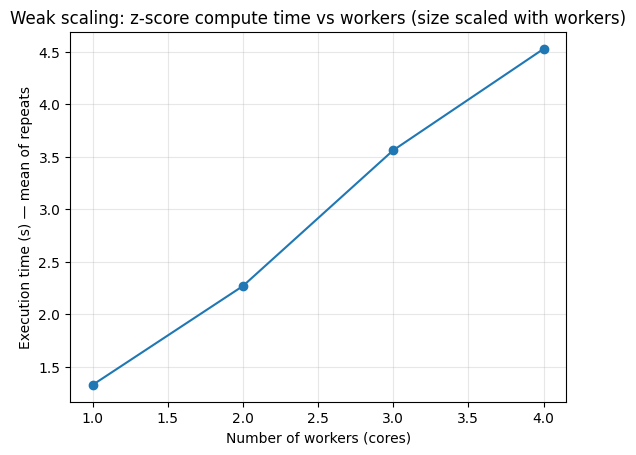

In [24]:
plt.figure()
plt.plot(df_weak["workers"], df_weak["time_mean_s"], marker="o")
plt.xlabel("Number of workers (cores)")
plt.ylabel("Execution time (s) — mean of repeats")
plt.title("Weak scaling: z-score compute time vs workers (size scaled with workers)")
plt.grid(True, alpha=0.3)
plt.savefig("weak_scaling_time.png", dpi=300, bbox_inches="tight")
plt.show()


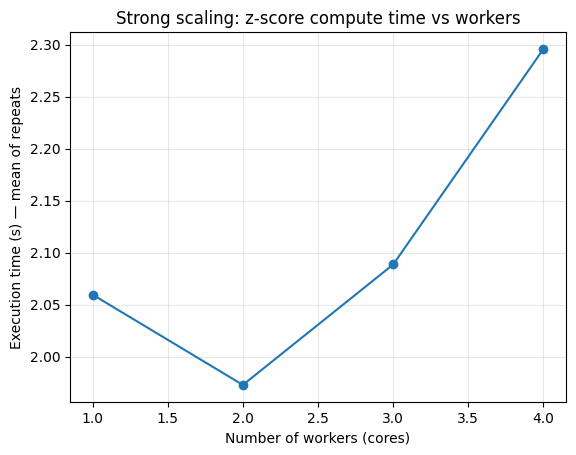

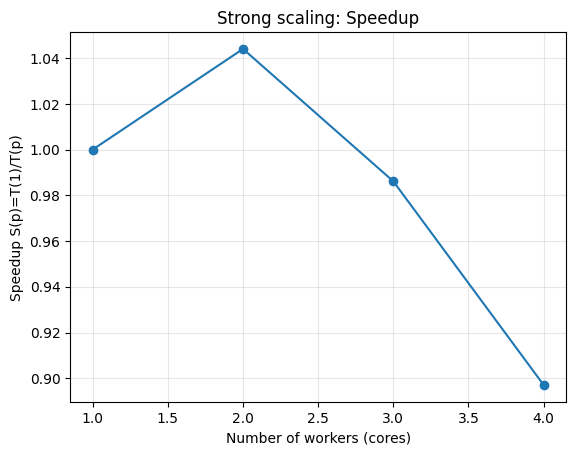

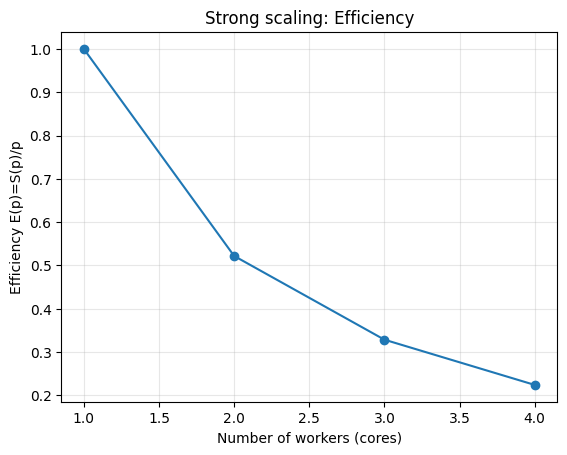

In [31]:
plt.figure()
plt.plot(df_strong["workers"], df_strong["time_mean_s"], marker="o")
plt.xlabel("Number of workers (cores)")
plt.ylabel("Execution time (s) — mean of repeats")
plt.title("Strong scaling: z-score compute time vs workers")
plt.grid(True, alpha=0.3)
plt.savefig("strong_scaling_time.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(df_strong["workers"], df_strong["speedup"], marker="o")
plt.xlabel("Number of workers (cores)")
plt.ylabel("Speedup S(p)=T(1)/T(p)")
plt.title("Strong scaling: Speedup")
plt.grid(True, alpha=0.3)
plt.savefig("strong_speedup.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(df_strong["workers"], df_strong["efficiency"], marker="o")
plt.xlabel("Number of workers (cores)")
plt.ylabel("Efficiency E(p)=S(p)/p")
plt.title("Strong scaling: Efficiency")
plt.grid(True, alpha=0.3)
plt.savefig("strong_efficiency.png", dpi=300, bbox_inches="tight")
plt.show()